Binary classification CNN using the fast.ai library. 

Using v3 dataset. 80/20 time-based train/valid split. Also have a 1 day independent test set.

In [1]:
from random import random
from pathlib import Path

# import * appears to be the fast.ai way of doing things,
# even though every instinct in me says "don't do this" :)
from fastai.vision import *  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [2]:
MODEL_NAME = "model_v2.1"

In [3]:
path = Path("~/data/split-v3-time").expanduser()

In [4]:
tfms = get_transforms(max_rotate=0, do_flip=False, max_zoom=1.05, max_warp=0, p_affine=0)
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [5]:
# def get_ex(): return open_image(random.choice(list((path / "train/BirdHome").glob("*.jpeg"))))

# def plots_f(rows, cols, width, height, **kwargs):
#     ex = get_ex()
#     [ex.apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
#         rows,cols,figsize=(width,height))[1].flatten())]

In [6]:
# plots_f(4, 5, 20, 20)

In [7]:
data = ImageDataBunch.from_folder(path, bs=28, ds_tfms=tfms)

In [8]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

# Train

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


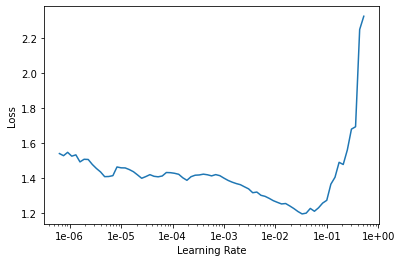

In [10]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.198536,0.175315,0.935832,15:01


In [12]:
learn.save(f"{MODEL_NAME}-frozen-epoch01")

In [13]:
learn.fit_one_cycle(1, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.125784,0.119656,0.957751,14:56


In [14]:
learn.save(f"{MODEL_NAME}-frozen-epoch02")

In [15]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


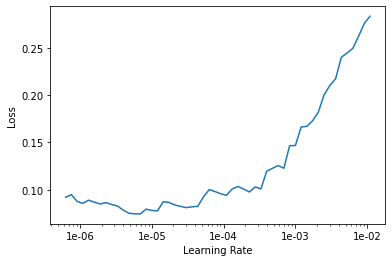

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
head_lr = 1e-4
learn.fit_one_cycle(2, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.076780,0.102712,0.964422,20:02
1,0.070014,0.097418,0.966328,20:06


In [18]:
learn.save(f"{MODEL_NAME}-frozen-epoch02-thaw-epoch04")

----

Let's backtrack a bit and check if keeping it frozen would've been better.

In [20]:
learn.load(f"{MODEL_NAME}-frozen-epoch02");

In [22]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.154294,0.217103,0.881830,20:03
1,0.066141,0.097563,0.963469,20:04


Ok, diverged on the first epoch. LR too high probably. Try same thing again with LR 1e-4.

----

In [23]:
learn.load(f"{MODEL_NAME}-frozen-epoch02");

In [24]:
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.084649,0.159614,0.951080,20:04
1,0.040183,0.063913,0.977128,20:04


Nice!

In [25]:
learn.save(f"{MODEL_NAME}-frozen-epoch04")

Now let's try to unfreeze.

In [26]:
learn.unfreeze()

In [27]:
head_lr = 1e-4
learn.fit_one_cycle(1, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.024268,0.064933,0.978081,20:00


We may be entering overfitting land now. But let's see where it goes.

In [28]:
learn.save(f"{MODEL_NAME}-frozen-epoch04-thaw-epoch05")

In [29]:
learn.fit_one_cycle(1, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.017442,0.059856,0.980623,19:59


In [30]:
learn.save(f"{MODEL_NAME}-frozen-epoch04-thaw-epoch06")

# Evaluate

In [31]:
pred_train = learn.get_preds(ds_type=DatasetType.Train)

In [32]:
accuracy(*pred_train)

tensor(0.9972)

In [33]:
pred_cv = learn.get_preds(ds_type=DatasetType.Valid)

In [34]:
accuracy(*pred_cv)

tensor(0.9806)

In [35]:
np.unique(pred_train[1], return_counts=True)

(array([0, 1]), array([10215,  2357]))

In [36]:
def sklearn_metrics(preds_output):
    preds, labels = preds_output
    pred_classes = (preds > .5).numpy().astype(int)[:, 1]
    
    acc = accuracy_score(labels, pred_classes)
    prec = precision_score(labels, pred_classes)
    recall = recall_score(labels, pred_classes)
    f1 = 2 * prec * recall / (prec + recall)

    print(f"Accuracy:  {acc:.3f}")  # Sanity check
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1:        {f1:.3f}")

In [37]:
sklearn_metrics(pred_train)

Accuracy:  0.997
Precision: 0.994
Recall:    0.992
F1:        0.993


In [38]:
sklearn_metrics(pred_cv)

Accuracy:  0.981
Precision: 0.921
Recall:    0.981
F1:        0.950


In [39]:
testdata = ImageDataBunch.from_folder(
    Path("~/data/labeled-test-set-cropped-unfiltered-20200529").expanduser(), bs=28, valid_pct=0)
testdata

ImageDataBunch;

Train: LabelList (1037 items)
x: ImageList
Image (3, 980, 800),Image (3, 980, 800),Image (3, 980, 800),Image (3, 980, 800),Image (3, 980, 800)
y: CategoryList
BirdHome,BirdHome,BirdHome,BirdHome,BirdHome
Path: /home/jvlier/data/labeled-test-set-cropped-unfiltered-20200529;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jvlier/data/labeled-test-set-cropped-unfiltered-20200529;

Test: None

In [40]:
learn.data = testdata
pred_test = learn.get_preds(ds_type=DatasetType.Train)
sklearn_metrics(pred_test)
accuracy(*pred_test)

Accuracy:  0.930
Precision: 0.972
Recall:    0.720
F1:        0.827


tensor(0.9295)

In [41]:
learn.export(f"{MODEL_NAME}-frozen-epoch04-thaw-epoch06")